<a href="https://colab.research.google.com/github/CallMeAaryan/GANfromScratch/blob/main/GAN_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Get the device information

In [ ]:
import torch
torch.cuda.get_device_name(device=None)

'Tesla T4'

#Load required libraries

In [ ]:
import torch
import torch.optim as opt
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import numpy as np
import matplotlib.pyplot as plt


# **Cifar-10 Dataset**


![cifar10 dataset](https://pytorch.org/tutorials/_images/cifar10.png)

In [ ]:
cifar_trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),transforms.Resize((64,64))]))
#cifar_testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))]))

100%|██████████| 170498071/170498071 [00:04<00:00, 36785423.81it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


In [ ]:
print(len(cifar_trainset))
#print(len(cifar_testset))

50000


In [ ]:
print(cifar_trainset)

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.201))
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
           )


In [ ]:
print(cifar_trainset[0])

(tensor([[[-1.2854, -1.3629, -1.5180,  ...,  0.4981,  0.4593,  0.4399],
         [-1.4937, -1.5713, -1.7264,  ...,  0.3466,  0.3248,  0.3139],
         [-1.9105, -1.9881, -2.1431,  ...,  0.0437,  0.0558,  0.0619],
         ...,
         [ 1.0457,  1.0093,  0.9366,  ..., -0.3718, -0.5415, -0.6263],
         [ 1.0166,  0.9754,  0.8930,  ...,  0.1176, -0.1198, -0.2386],
         [ 1.0021,  0.9584,  0.8712,  ...,  0.3624,  0.0910, -0.0447]],

        [[-1.1989, -1.2776, -1.4349,  ...,  0.0352,  0.0254,  0.0204],
         [-1.4054, -1.4890, -1.6562,  ..., -0.1652, -0.1627, -0.1615],
         [-1.8184, -1.9118, -2.0987,  ..., -0.5659, -0.5388, -0.5253],
         ...,
         [ 0.3400,  0.2626,  0.1077,  ..., -0.9887, -1.1190, -1.1842],
         [ 0.3892,  0.3142,  0.1642,  ..., -0.4798, -0.6937, -0.8007],
         [ 0.4138,  0.3400,  0.1925,  ..., -0.2254, -0.4811, -0.6089]],

        [[-0.9922, -1.0800, -1.2556,  ..., -0.2265, -0.2167, -0.2118],
         [-1.2020, -1.2922, -1.4727,  ..., -

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [ ]:
classes = cifar_trainset.classes
print('Number of Classes:', len(classes))
print('Class Names :\n', classes)

Number of Classes: 10
Class Names :
 ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


## Preserve only a few samples with a particular class label

In [ ]:
def get_indices(dataset):
    indices =  []
    for i in range(len(dataset.targets)):
        if dataset.targets[i] == 7:
            indices.append(i)   #indices of data with label 7
    return indices

In [ ]:
idx = get_indices(cifar_trainset)
print('Num Train Samples with labels 7:', len(idx))

Num Train Samples with labels 7: 5000


In [ ]:
batch_size = 16
trainLoader = torch.utils.data.DataLoader(cifar_trainset,batch_size=batch_size,
                                          sampler = torch.utils.data.sampler.SubsetRandomSampler(idx))

In [ ]:
#Set up an iterator for data loader and get the next batch
dataIter = iter(trainLoader)
imgs, labels = next(dataIter)

In [ ]:
#Print
imgs.shape  #shape of the tensor data obtained from the train loader

torch.Size([16, 3, 64, 64])

In [ ]:
#visualization of data on a grid
def imshow_RGB(imgs):
    imgs = torchvision.utils.make_grid(imgs)
    imgs = imgs.cpu()
    npimgs = imgs.numpy()
    imgs[0] = imgs[0] * 0.2023 + 0.4914
    imgs[1] = imgs[1] * 0.1994 + 0.4822
    imgs[2] = imgs[2] * 0.2010 + 0.4465
    plt.figure(figsize=(8,8))
    T = torchvision.transforms.Resize((32,32))
    imgs = T(imgs)
    plt.imshow(np.transpose(npimgs, (1,2,0)))
    plt.xticks([])
    plt.yticks([])
    plt.show()

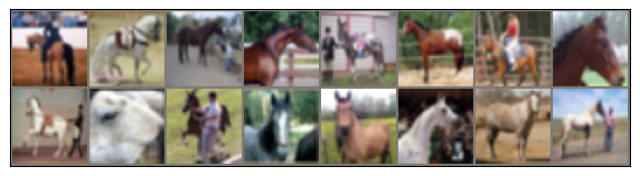

In [ ]:
imshow_RGB(imgs) #using imshow() to obtain the grid

## Create DC GAN Generator

In [ ]:
# Generator Code
nc = 3  # Number of channels in the training images. For color images this is 3
nz = 100  # Size of z latent vector (i.e. size of generator input)
ngf = 64  # Size of feature maps in generator

class DC_Gen(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.model(input)

In [ ]:
DC_G = DC_Gen()

## Create DC GAN Discriminator

In [ ]:
#Discriminator Code
ndf = 64  # Size of feature maps in discriminator

class DC_Dis(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.model(input)

In [ ]:
DC_D = DC_Dis()

In [ ]:
if (torch.cuda.is_available()):
    DC_D.cuda()
    DC_G.cuda()

print(DC_G)
print(DC_D)

DC_Gen(
  (model): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)
DC

## Set up learning rate and optimizers for generator and discriminator

In [ ]:
lr = 1e-3  #learning rate
#optimizers for both models
G_opt = opt.Adam(DC_G.parameters(), lr=lr)
D_opt = opt.Adam(DC_D.parameters(), lr=lr)

## Training module for DC GAN Architecture

Epoch:0,   G_loss:9.446705251456068,    D_loss:0.19385991768521693


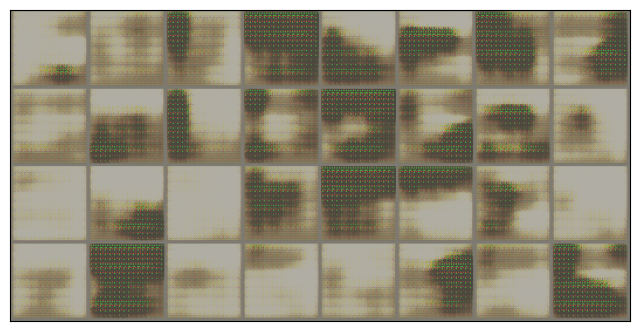

Epoch:1,   G_loss:10.700648781590568,    D_loss:0.142382556977918
Epoch:2,   G_loss:9.613746347518775,    D_loss:0.15354808873741776
Epoch:3,   G_loss:10.60754508637011,    D_loss:0.19256494897647394
Epoch:4,   G_loss:10.244550343900443,    D_loss:0.15823916772749802
Epoch:5,   G_loss:10.870485722447356,    D_loss:0.20111175835442094
Epoch:6,   G_loss:10.029072732971118,    D_loss:0.21224493230720937
Epoch:7,   G_loss:10.101625229223087,    D_loss:0.21803191229097224
Epoch:8,   G_loss:10.04941975123014,    D_loss:0.22343278405346914
Epoch:9,   G_loss:11.287048422109585,    D_loss:0.2803229973844696
Epoch:10,   G_loss:9.41505869204244,    D_loss:0.19565853164676344


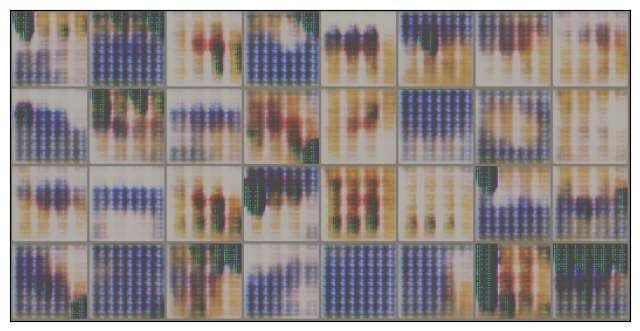

Epoch:11,   G_loss:10.892335198557795,    D_loss:0.2598332951818305
Epoch:12,   G_loss:9.49279531579429,    D_loss:0.29437634999695594
Epoch:13,   G_loss:8.374881010847732,    D_loss:0.44232252194144844
Epoch:14,   G_loss:7.4724618211721845,    D_loss:0.3299185830453327
Epoch:15,   G_loss:7.838733062195701,    D_loss:0.287893475984006
Epoch:16,   G_loss:8.118038806671533,    D_loss:0.29569018187907753
Epoch:17,   G_loss:7.948093389931579,    D_loss:0.27061434887252345
Epoch:18,   G_loss:7.948866024946633,    D_loss:0.3742088014445901
Epoch:19,   G_loss:6.783260409062663,    D_loss:0.23960376961733967
Epoch:20,   G_loss:7.868396748369113,    D_loss:0.2548523408533915


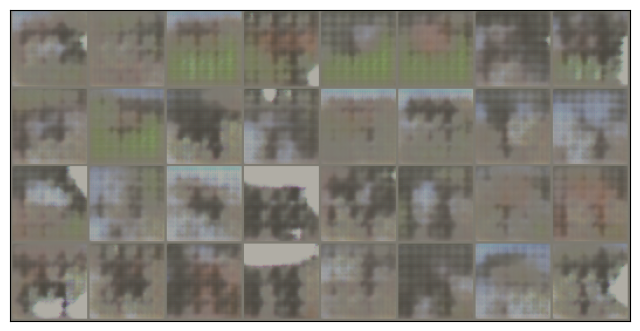

Epoch:21,   G_loss:7.3349745182183606,    D_loss:0.20010396969499447
Epoch:22,   G_loss:7.8940283178140565,    D_loss:0.3133028190361318
Epoch:23,   G_loss:6.866361929966619,    D_loss:0.3557820480222778
Epoch:24,   G_loss:7.160733567640042,    D_loss:0.2978477701654482
Epoch:25,   G_loss:6.518951510468992,    D_loss:0.2471430043439967
Epoch:26,   G_loss:6.989702221684563,    D_loss:0.2744364463054715
Epoch:27,   G_loss:7.646403027037843,    D_loss:0.2730517275181388
Epoch:28,   G_loss:7.293632166073345,    D_loss:0.23000779271961902
Epoch:29,   G_loss:7.173649313350836,    D_loss:0.2849539446779497
Epoch:30,   G_loss:7.162650566893264,    D_loss:0.3043304956008564


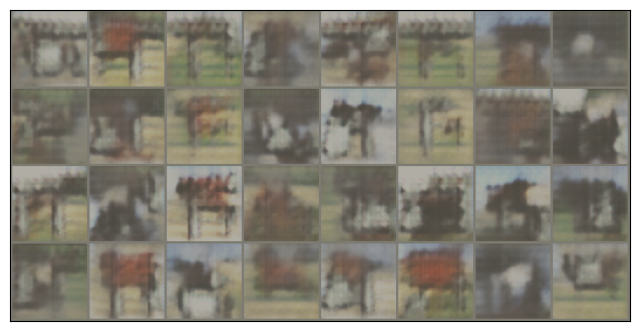

Epoch:31,   G_loss:6.804995814832255,    D_loss:0.21953323833680097
Epoch:32,   G_loss:7.024895973479786,    D_loss:0.3112777048207153
Epoch:33,   G_loss:6.843900019368425,    D_loss:0.3188108648947134
Epoch:34,   G_loss:6.805701025377828,    D_loss:0.3600469488039101
Epoch:35,   G_loss:6.5237940858347345,    D_loss:0.3852755081651661
Epoch:36,   G_loss:6.402253754222736,    D_loss:0.30020291919146064
Epoch:37,   G_loss:6.16925108699372,    D_loss:0.2981674276714841
Epoch:38,   G_loss:6.121129096125642,    D_loss:0.3633543318836762
Epoch:39,   G_loss:6.165999731697594,    D_loss:0.2888477941909537
Epoch:40,   G_loss:6.228362646346656,    D_loss:0.3561078215095277


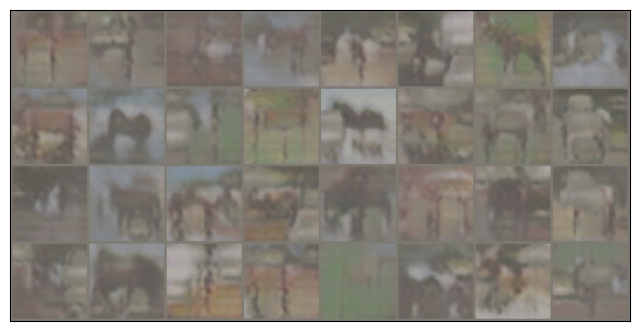

Epoch:41,   G_loss:7.431762855273847,    D_loss:0.2223894992083967
Epoch:42,   G_loss:6.936523368183416,    D_loss:0.2969561317348302
Epoch:43,   G_loss:6.206622268826055,    D_loss:0.3607286467498091
Epoch:44,   G_loss:7.116218182606438,    D_loss:0.291004174046022
Epoch:45,   G_loss:6.558856434334581,    D_loss:0.2750190957583273
Epoch:46,   G_loss:6.3272529497695045,    D_loss:0.35145196274812585
Epoch:47,   G_loss:7.017454116108318,    D_loss:0.1997809152477964
Epoch:48,   G_loss:6.851224993745359,    D_loss:0.30865466521053125
Epoch:49,   G_loss:6.68601823538637,    D_loss:0.31777961006516015
Epoch:50,   G_loss:6.36133599205139,    D_loss:0.2423949251420046


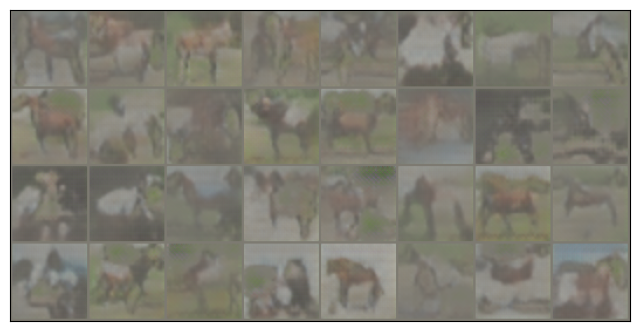

Epoch:51,   G_loss:6.55816568734166,    D_loss:0.2763720764852941
Epoch:52,   G_loss:6.671152453072155,    D_loss:0.368715740296954
Epoch:53,   G_loss:6.64016750293037,    D_loss:0.25739303247083706
Epoch:54,   G_loss:6.314439494769794,    D_loss:0.25647660043795767
Epoch:55,   G_loss:6.513908775850607,    D_loss:0.30435102059023855
Epoch:56,   G_loss:6.22470015001754,    D_loss:0.30815728486979754
Epoch:57,   G_loss:6.524642962617234,    D_loss:0.2821455239995231
Epoch:58,   G_loss:6.720525784995228,    D_loss:0.3093431577158604
Epoch:59,   G_loss:6.071741052328969,    D_loss:0.23148490456170953
Epoch:60,   G_loss:6.650246578283584,    D_loss:0.28968604119809216


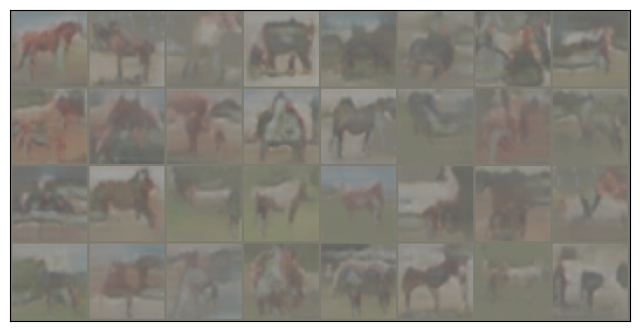

Epoch:61,   G_loss:6.491569699570775,    D_loss:0.3026535619093409
Epoch:62,   G_loss:6.245996101214863,    D_loss:0.2777372065116279
Epoch:63,   G_loss:6.28468374627086,    D_loss:0.20498818783654857
Epoch:64,   G_loss:6.584830578523703,    D_loss:0.39022566834925865
Epoch:65,   G_loss:6.54690571867239,    D_loss:0.2990726575786516
Epoch:66,   G_loss:6.28686991286354,    D_loss:0.2878962005715454
Epoch:67,   G_loss:6.166002816666429,    D_loss:0.3093253000916098
Epoch:68,   G_loss:6.497127774424446,    D_loss:0.2605022574379183
Epoch:69,   G_loss:6.462408717447957,    D_loss:0.26269216694833397
Epoch:70,   G_loss:6.47719799900969,    D_loss:0.2534940280600454


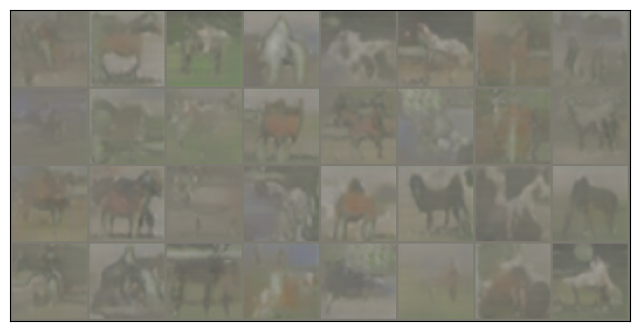

Epoch:71,   G_loss:6.256080491855122,    D_loss:0.3389667679865163
Epoch:72,   G_loss:6.72686016750031,    D_loss:0.2940061335175182
Epoch:73,   G_loss:6.209706453850475,    D_loss:0.35302797713266393
Epoch:74,   G_loss:6.165700629877207,    D_loss:0.22521134296479745
Epoch:75,   G_loss:6.557837058941777,    D_loss:0.29046397841946126
Epoch:76,   G_loss:6.302674340744749,    D_loss:0.25554528117355424
Epoch:77,   G_loss:6.5202068665537976,    D_loss:0.2306007508920452
Epoch:78,   G_loss:6.451476048356809,    D_loss:0.2882781658878032
Epoch:79,   G_loss:6.418561149329042,    D_loss:0.2499732930174532
Epoch:80,   G_loss:6.472099423027648,    D_loss:0.27603001201141497


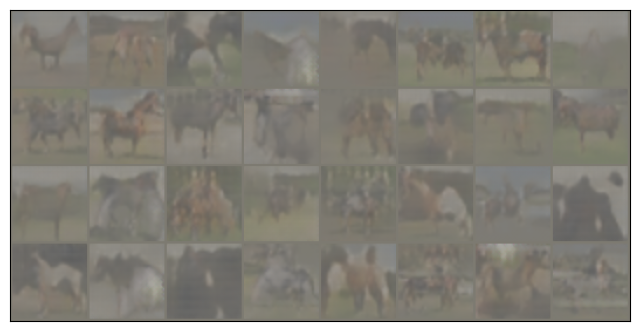

Epoch:81,   G_loss:6.436440557336655,    D_loss:0.2774777652442116
Epoch:82,   G_loss:6.323037063732696,    D_loss:0.22560487014164154
Epoch:83,   G_loss:6.2747977937753205,    D_loss:0.2292831535942067
Epoch:84,   G_loss:6.565957368753208,    D_loss:0.19900690344870448
Epoch:85,   G_loss:6.625755504297373,    D_loss:0.30538759070479077
Epoch:86,   G_loss:6.438309056309466,    D_loss:0.23170611666316113
Epoch:87,   G_loss:6.481858716605189,    D_loss:0.19311245890652623
Epoch:88,   G_loss:7.271388341824467,    D_loss:0.3226838410198212
Epoch:89,   G_loss:6.470066974719112,    D_loss:0.3935382983084923
Epoch:90,   G_loss:6.387114979588566,    D_loss:0.2948271412749778


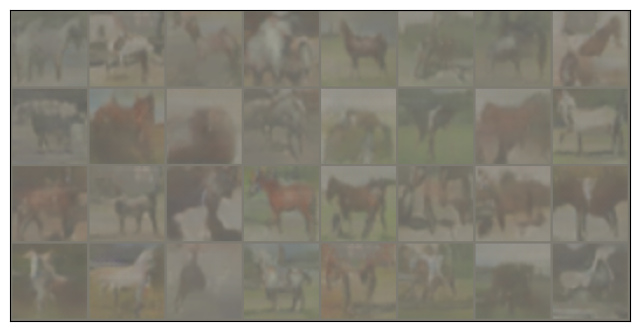

Epoch:91,   G_loss:6.386990136612718,    D_loss:0.25519288334394463
Epoch:92,   G_loss:6.416418320073868,    D_loss:0.20087884612955725
Epoch:93,   G_loss:6.274912359234624,    D_loss:0.2674902872102091
Epoch:94,   G_loss:6.456848580997211,    D_loss:0.26582820034517457
Epoch:95,   G_loss:6.720540671302868,    D_loss:0.1521631654767772
Epoch:96,   G_loss:6.889728987178864,    D_loss:0.1869706890706461
Epoch:97,   G_loss:6.59365388227347,    D_loss:0.21093399379069147
Epoch:98,   G_loss:6.88512160679022,    D_loss:0.24287110640289494
Epoch:99,   G_loss:6.886276894103224,    D_loss:0.2217098488922442
Saving the final model state dictionary...at DC_G.dth and DC_D.dth


In [ ]:
G_losses = []
D_losses = []

best_G_loss = 0
best_D_loss = 0

real_label = 1.0
fake_label = 0.0

max_epochs = 100

for epoch in range(max_epochs):
  G_loss_run = 0.0
  D_loss_run = 0.0

  for i, data in enumerate(trainLoader):
    X, _ = data #labels of images are not very relevant
    batch_size = X.size(0)
    label = torch.full((batch_size,), real_label)
    label_f = torch.full((batch_size,), fake_label)

    z = torch.randn(batch_size,nz,1,1)
    fixed_noise = torch.randn(32, nz, 1, 1)

    if (torch.cuda.is_available()):
      X = X.cuda()
      label = label.cuda()
      z = z.cuda()
      label_f = label_f.cuda()
      fixed_noise = fixed_noise.cuda()

    ## DISCRIMINATOR TRAINING
    #train with real
    DC_D.zero_grad()

    D_real = DC_D(X)
    D_real = D_real.squeeze(1).squeeze(1).squeeze(1)
    D_real_loss = F.binary_cross_entropy(D_real, label)  #loss -(1/m)(log D(x))
    #D_real_loss.backward()


    #train with fake
    fake = DC_G(z)
    #label.fill(fake_label)
    D_fake = DC_D(fake.detach())
    D_fake = D_fake.squeeze(1).squeeze(1).squeeze(1)
    D_fake_loss = F.binary_cross_entropy(D_fake, label_f)  #loss -(1/m)(log(1-D(G(z))))

    D_loss = D_real_loss + D_fake_loss

    D_loss.backward()
    D_opt.step()


    #GENERATOR training
    D_fake = DC_D(fake)

    D_fake = D_fake.squeeze(1).squeeze(1).squeeze(1)
    G_loss = F.binary_cross_entropy(D_fake, label)  #loss -(1/m)(log (1-D(G(z))))

    G_opt.zero_grad()
    G_loss.backward()
    G_opt.step()

    G_loss_run += G_loss.item()
    D_loss_run += D_loss.item()

  print('Epoch:{},   G_loss:{},    D_loss:{}'.format(epoch, G_loss_run/(i+1), D_loss_run/(i+1)))

  G_losses.append(G_loss_run/(i+1))
  D_losses.append(D_loss_run/(i+1))

  if epoch%10 == 0:
    with torch.no_grad():
      samples = DC_G(fixed_noise).detach()
      samples = samples.view(samples.size(0), 3, 64, 64)
      imshow_RGB(samples)



#Saving the best model
print("Saving the final model state dictionary...at DC_G.dth and DC_D.dth")
torch.save(DC_G.state_dict(), "DC_G.dth")
torch.save(DC_D.state_dict(), "DC_D.dth")

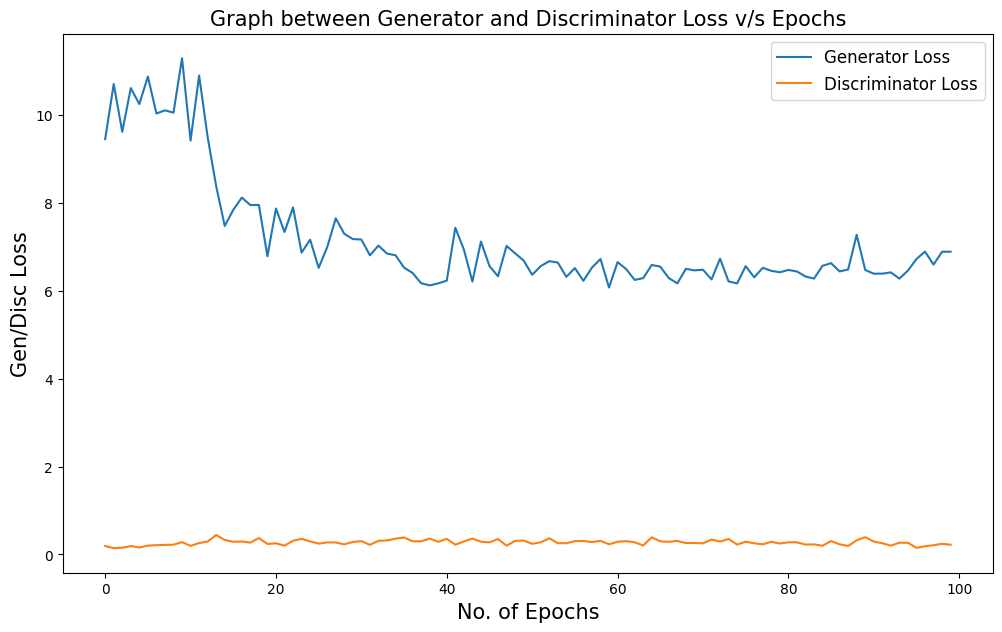

In [ ]:
#Plot losses
x_range = np.arange(0,max_epochs)
plt.figure(figsize =(12,7))
plt.plot(x_range,G_losses,label = "Generator Loss")
plt.plot(x_range,D_losses,label = "Discriminator Loss")
plt.ylabel("Gen/Disc Loss",fontsize = 15)
plt.xlabel("No. of Epochs",fontsize = 15)
plt.legend(fontsize = 12,loc = "best")
plt.title("Graph between Generator and Discriminator Loss v/s Epochs",fontsize = 15)
plt.show()


## Showing the generated images one last time

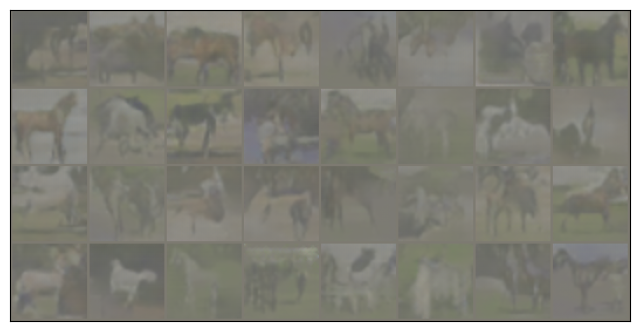

In [ ]:
fixed_noise = torch.randn(32, nz, 1, 1)
if torch.cuda.is_available():
  fixed_noise = fixed_noise.cuda()
with torch.no_grad():
    samples = DC_G(fixed_noise).detach()
    samples = samples.view(samples.size(0), 3, 64, 64)
    imshow_RGB(samples)